# Assignment 4

#### Student ID: *M112040034*

#### Name: *李祐瑄*

To ensure reproducibility, please set all the random seeds to 2023:

In [ ]:
%pip install git+https://github.com/tensorflow/similarity.git -qq
%pip install tensorflow-addons -qq
%pip install transformers datasets evaluate -qq

## Q1 Transfer learning on the dataset used by the CNN explainer

[CNN Explainer](https://poloclub.github.io/cnn-explainer/) is an interactive, open-source visualization tool designed to provide a comprehensive understanding of Convolutional Neural Networks (CNNs). In the last assignment, we tried to replicate the original experiment using TinyVGG by training the model from scratch. However, the results are not satisfactory. In this exercise, we will continue our journey and leverage transfer learning to improve the performance on the given test dataset. First, load the dataset using the following code (Feel free to change the code if you want to use `Pytorch` or other frameworks.):

In [2]:
!unzip -qq data_hw3.zip

In [3]:
training_images = 'class_10_train/'
vali_images = 'class_10_val/val_images/'
test_images = 'class_10_val/test_images/'

In [2]:
import numpy as np
import tensorflow as tf
np.random.seed(2023)
tf.random.set_seed(2023)

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
import json

#讀取json獲取label資訊
with open('/content/class_dict.json', 'r') as f:
    labels_info = json.load(f)

class_names = list(labels_info.keys())

train_dataset = image_dataset_from_directory(
    training_images,
    image_size = (64, 64),
    batch_size=32,
    class_names=class_names,
    label_mode='categorical'
)
validation_dataset = image_dataset_from_directory(
    vali_images,
    image_size = (64, 64),
    batch_size=32,
    class_names=class_names,
    label_mode='categorical'
)
test_dataset = image_dataset_from_directory(
    test_images,
    image_size = (64, 64),
    batch_size=32,
    class_names=class_names,
    label_mode='categorical'
)

Found 5000 files belonging to 10 classes.
Found 250 files belonging to 10 classes.
Found 250 files belonging to 10 classes.


#### (a) EfficientNet is a modern convnets obtained from [network architecture search](https://lilianweng.github.io/posts/2020-08-06-nas/). We will use it to perform transfer learning by using the following procedure: (10%)

1. First, add the callback to monitor the validation loss and save the best model base on the validation loss. 

2. Import the convolutional base of `EfficientNetV2S` (`efficientnet_v2_s`) and pre-trained weight from ImageNet. Try to freeze all the weights in the convolutional base. 

3. Add a dropout layer after the convolutional base (remember to flatten the output of the base before dropout) with a dropout rate set to 0.5, followed by a dense layer with softmax activation to classify the given 10 classes.

4. Train the model for 10 epochs using `Adam` optimizer with default learning rate. Finally, report the accuracy of the test set. Remember to reload the best model before the test.

Hint: Remember you may need different input preprocessing for each pre-train model. Checkout the documentation for that pretrain model first.

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.optimizers import Adam

#添加回調函數以監控驗證損失並保存最佳模型
checkpoint = ModelCheckpoint(
    "best_model_a.h5",
    monitor='val_loss',
    save_best_only=True)

#導入 EfficientNetV2S 模型和預訓練權重
conv_base = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
#freeze EfficientNetV2S 的所有權重
conv_base.trainable = False

#在conv_base之後添加 Dropout 層和全連接層
model = tf.keras.Sequential([
    conv_base,
    Flatten(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
#編譯&訓練
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[checkpoint]
)
#重新載入最佳模型
best_model = tf.keras.models.load_model('best_model_a.h5')
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print("Test accuracy:", test_accuracy)

82420632/82420632 [==============================] - 5s 0us/step
Epoch 1/10
157/157 [==============================] - 37s 51ms/step - loss: 0.6567 - accuracy: 0.8028 - val_loss: 0.3511 - val_accuracy: 0.8960
Epoch 2/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2958 - accuracy: 0.9094 - val_loss: 0.3166 - val_accuracy: 0.8920
Epoch 3/10
157/157 [==============================] - 5s 29ms/step - loss: 0.2327 - accuracy: 0.9252 - val_loss: 0.2941 - val_accuracy: 0.9040
Epoch 4/10
157/157 [==============================] - 5s 34ms/step - loss: 0.1934 - accuracy: 0.9424 - val_loss: 0.2724 - val_accuracy: 0.9000
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1635 - accuracy: 0.9490 - val_loss: 0.2620 - val_accuracy: 0.9000
Epoch 6/10
157/157 [==============================] - 4s 23ms/step - loss: 0.1423 - accuracy: 0.9552 - val_loss: 0.2725 - val_accuracy: 0.9000
Epoch 7/10
157/157 [==============================] - 5s 30ms/step - loss: 0

#### (b) Looking at the training/validation loss, you can see that the model is overfitting. Try to add a data augmentation layer for the model in (a) as follows: (10%)

* Applies random horizontal flipping 
* Rotates the input images by a random value in the range `[–36 degrees, +36 degrees]`)
* Zooms in or out of the image by a random factor in the range `[-20%, +20%]`
* Randomly choose a location to crop images down to a target size `[56, 56]`
* Randomly adjust the contrast of images so that the resulting images are `[0.85, 1.15]` brighter or darker than the original one.

In addition, unfreeze the last three layers of the convolutional base (i.e., We will fine-tune the last three layers and the classification head). Fit your model using `Adam` optimizer for enough epochs (40, for instance). Finally, report the accuracy of the test set. Remember to reload the best model before the test.

Hint: You can find out how to apply the data augmentation in the previous lab. Notice that to make the shape compatible, you need to construct the convolutional base with a different size that meets the output of the data augmentation layer.

In [7]:
# coding your answer here.
from tensorflow.keras.layers import experimental
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.optimizers import Adam


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_b.h5',
    monitor='val_loss',
    save_best_only=True,
)

#建立增強層
aug_layer = Sequential([
        experimental.preprocessing.RandomFlip("horizontal"),  #隨機水平翻轉
        experimental.preprocessing.RandomRotation(factor=0.1),  # 隨機旋轉正負36度
        experimental.preprocessing.RandomZoom((-0.2, 0.2)),  # 隨機縮放正負20%
        experimental.preprocessing.RandomCrop(56, 56),  #隨機裁剪成56*56
        experimental.preprocessing.RandomContrast(factor=(0.85, 1.15))  #隨機調整亮度
    ])
#修改輸入大小
input_shape = (56, 56, 3)
conv_base = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)

#建立加上增強層的模型
model = tf.keras.Sequential([
    aug_layer,
    conv_base,
    Flatten(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

#unfreeze最後三層
conv_base.trainable = True
for layer in conv_base.layers[:-3]:
    layer.trainable = False
    
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=40,
    callbacks=[checkpoint]
)
# 重新載入最佳模型
best_model = tf.keras.models.load_model('best_model_b.h5')
# 在測試集上評估準確度
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print('Test Accuracy:', test_accuracy)

Epoch 1/40
157/157 [==============================] - 30s 60ms/step - loss: 0.8298 - accuracy: 0.7264 - val_loss: 0.4004 - val_accuracy: 0.8760
Epoch 2/40
157/157 [==============================] - 5s 29ms/step - loss: 0.5412 - accuracy: 0.8296 - val_loss: 0.3884 - val_accuracy: 0.8760
Epoch 3/40
157/157 [==============================] - 6s 37ms/step - loss: 0.4918 - accuracy: 0.8450 - val_loss: 0.3685 - val_accuracy: 0.8640
Epoch 4/40
157/157 [==============================] - 5s 29ms/step - loss: 0.4471 - accuracy: 0.8608 - val_loss: 0.3653 - val_accuracy: 0.8920
Epoch 5/40
157/157 [==============================] - 6s 35ms/step - loss: 0.4346 - accuracy: 0.8654 - val_loss: 0.3633 - val_accuracy: 0.8960
Epoch 6/40
157/157 [==============================] - 5s 31ms/step - loss: 0.3917 - accuracy: 0.8792 - val_loss: 0.3269 - val_accuracy: 0.9120
Epoch 7/40
157/157 [==============================] - 5s 29ms/step - loss: 0.4023 - accuracy: 0.8772 - val_loss: 0.2768 - val_accuracy: 0.928

#### (c) `CLIP` is a foundation model that contains both text and image encoder. The multimodal nature makes it possible to conduct zero-shot classification. In this problem, we will leverage it to perform the classification. (15%)

1. Firstly, try to load the model and processor with checkpoint [`openai/clip-vit-large-patch14`](https://huggingface.co/openai/clip-vit-large-patch14) from hugging face. You can use `TFAutoModelForZeroShotImageClassification`(or `AutoModelForZeroShotImageClassification`) and `AutoProcessor` to load the model.

2. Secondly, use the following mapping to generate the candidate text labels: 
```
{'n01882714': 'koala', 
 'n02165456': 'ladybug', 
 'n02509815': 'lesser panda', 
 'n03662601': 'lifeboat', 
 'n04146614': 'school bus', 
 'n04285008': 'sports car', 
 'n07720875': 'bell pepper', 
 'n07747607': 'orange', 
 'n07873807': 'pizza', 
 'n07920052': 'espresso'}
```

3. Thirdly, perform zero-shot 10 class classification using the processor and the `CLIP` model on the test dataset. 

4. Finally, calculate the accuracy on the test dataset.

Hint: If you are using `image_dataset_from_directory` function, it will assign labels to images based on their directory names. The labels are integer indices of the class names sorted alphabetically (i.e., 'n01882714'-> 0, 'n02165456'-> 1 ...). In addition, refer to our lab to see how to perform zero-shot classification. Finally, remember that you can extract the image data and labels from the test set into `X` and `y` `NumPy` arrays.

In [12]:
import tensorflow as tf
from transformers import TFAutoModelForZeroShotImageClassification, AutoProcessor
from sklearn.metrics import accuracy_score
import numpy as np
from PIL import Image

# 載入 CLIP model 和 processor
checkpoint = "openai/clip-vit-large-patch14"
model = TFAutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

# 候選文字mapping
mapping = {
    'n01882714': 'koala',
    'n02165456': 'ladybug',
    'n02509815': 'lesser panda',
    'n03662601': 'lifeboat',
    'n04146614': 'school bus',
    'n04285008': 'sports car',
    'n07720875': 'bell pepper',
    'n07747607': 'orange',
    'n07873807': 'pizza',
    'n07920052': 'espresso'
}
# 建立候選文字標籤
candidate_labels = list(mapping.values())
# 反轉mapping
reversed_mapping = {value: key for key, value in mapping.items()}

# 初始化正確分類&預測總數值
correct_predictions = 0
total_predictions = 0

# 遍歷測試集，每次處理一個圖像
for images, true_labels in test_dataset:
    for image, true_label in zip(images, true_labels):
        # 轉換圖像格式
        image = image.numpy().astype(np.uint8)
        image = Image.fromarray(image)

        # 進行分類
        inputs = processor(images=image, text=candidate_labels, return_tensors="tf", padding=True)
        outputs = model(**inputs)

        # 取得預測標籤
        logits_per_image = outputs.logits_per_image[0]
        probs = tf.nn.softmax(logits_per_image, axis=-1).numpy()
        predicted_label = candidate_labels[np.argmax(probs)]
        
        # 從真實標籤的 one-hot 編碼轉換為資料夾名稱
        true_label_folder_name = class_names[np.argmax(true_label.numpy())]

        # 如果預測的標籤對應的資料夾名稱與真實標籤的資料夾名稱相同，則增加正確預測的數量
        if reversed_mapping[predicted_label] == true_label_folder_name:
            correct_predictions += 1

        # 增加總預測的數量
        total_predictions += 1

# 計算準確率
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy}')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-large-patch14.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Accuracy: 0.964


#### (d) [Stable diffusion](https://huggingface.co/blog/stable_diffusion) is a text-to-image model that can generate high-quality images using a diffusion model. Try to design a prompt (e.g.: "a photo of ...") to generate three realistic photos that belong to one of the given 10 classes in the CNN explainer (i.e.:koala, ladybug....) using `diffuser` (`StableDiffusionPipeline`) or `KerasCV` (`keras_cv.models.StableDiffusion`). Finally, plot the above three generated images. (15%)

Hint: Refer to our lab to see how to use stable diffusion.

In [ ]:
!pip install --upgrade keras-cv

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
492466864/492466864 [==============================] - 2s 0us/step


3439090152/3439090152 [==============================] - 21s 0us/step


25/25 [==============================] - 20s 796ms/step


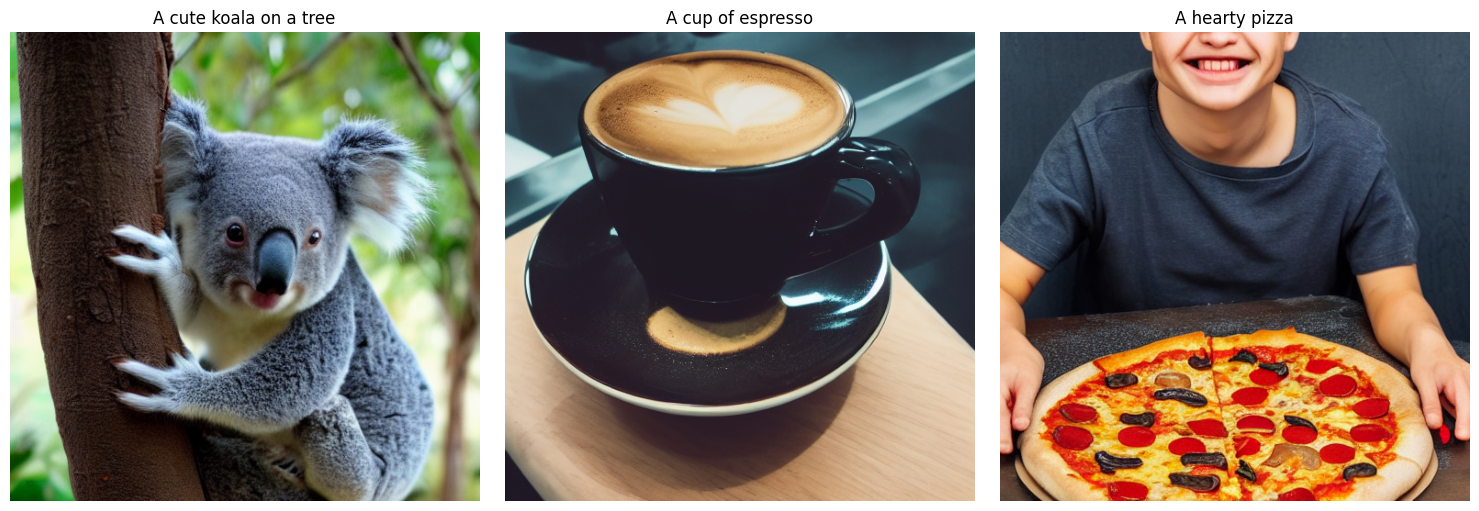

In [13]:
# coding your answer here.
import keras_cv
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt

# 創建 StableDiffusion 模型實例
model = keras_cv.models.StableDiffusion(img_height=512, img_width=512, jit_compile=True)

# 定義類別提示
prompts = ["A cute koala on a tree", "A cup of espresso", "A hearty pizza"]

# 為每個提示生成圖片
for i, prompt in enumerate(prompts):
    img = model.text_to_image(
        prompt=prompt,
        batch_size=1,
        num_steps=25,
        seed=2023,
    )
    # 將生成的圖片轉換為 PIL 圖片並保存
    Image.fromarray(img[0]).save(f"gen_image_{i}.png")

#顯示生成的圖片
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, prompt in enumerate(prompts):
    # 打開剛剛保存的圖片
    image = Image.open(f"gen_image_{i}.png")
    # 顯示圖片&標題
    axes[i].imshow(image)
    axes[i].set_title(prompt)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### (e) Firstly, resize the three images you generate in (e) into $64 \times 64$ pixels. Secondly, use the best model you found in (a)-(b) and the `CLIP` model in (c) to perform inference on these three downsample images. Are the results from the two models correct on all three images? (10%)

Hint: You can use PIL/OpenCV/Skimage or even NumPy to resize the images.

In [16]:
# coding your answer here.
from PIL import Image
import numpy as np
import tensorflow as tf
from transformers import TFAutoModelForZeroShotImageClassification, AutoProcessor

#resize image
img_path = ["gen_image_0.png", "gen_image_1.png", "gen_image_2.png"]
resized_images = []
for path in img_path:
  img = Image.open(path)
  img = img.resize((64, 64))
  img = np.array(img)
  resized_images.append(img)

#加載模型
best_model_a = tf.keras.models.load_model('best_model_a.h5')
best_model_b = tf.keras.models.load_model('best_model_b.h5')
model = TFAutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
#進行預測
for i, img in enumerate(resized_images):
  img = np.expand_dims(img, axis=0)
  pred_a = best_model_a.predict(img)
  pred_b = best_model_b.predict(img)
  print(f'Prediction on gen_image_{i}')
  print("Model A prediction:", mapping[class_names[np.argmax(pred_a)]])
  print("Model B prediction:", mapping[class_names[np.argmax(pred_b)]])
print("-----CLIP model-----")
for i, img in enumerate(resized_images):
  img = np.expand_dims(img, axis=0)
  # 進行分類
  inputs = processor(images=img, text=candidate_labels, return_tensors="tf", padding=True)
  outputs = model(**inputs)
  # 取得預測標籤
  logits_per_image = outputs.logits_per_image[0]
  probs = tf.nn.softmax(logits_per_image, axis=-1).numpy()
  predicted_label = candidate_labels[np.argmax(probs)]
  print(f'Prediction on gen_image_{i}')
  print("CLIP model prdiction:", predicted_label)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-large-patch14.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


1/1 [==============================] - 4s 4s/step
Prediction on gen_image_0
Model A prediction: koala
Model B prediction: lesser panda
1/1 [==============================] - 0s 55ms/step
Prediction on gen_image_1
Model A prediction: espresso
Model B prediction: espresso
1/1 [==============================] - 0s 61ms/step
Prediction on gen_image_2
Model A prediction: pizza
Model B prediction: pizza
-----CLIP model-----
Prediction on gen_image_0
CLIP model prdiction: koala
Prediction on gen_image_1
CLIP model prdiction: espresso
Prediction on gen_image_2
CLIP model prdiction: pizza


> Ans: 從(d)的生成結果，第一張圖到第三張圖，分別是koala, espresso, pizza，而(a)訓練出的model和(c)所使用的CLIP model皆預測正確，但(b)訓練出的model在預測第一張圖時(gen_image_0)，把koala錯誤預測為lesser panda

## Q2 Analyze sentiment dataset using different models

[Sentiment analysis](https://demo.allennlp.org/sentiment-analysis/glove-sentiment-analysis) is a subfield of natural language processing (NLP) that involves determining the emotional tone behind words. Its purpose is to understand the attitudes, opinions, and emotions of a speaker or writer with respect to some topic or the overall contextual polarity of a document. In this problem, we will use the dataset that comes from three different websites/fields:
`imdb.com`, `amazon.com` and `yelp.com` and we will classify each sentence as positive(1) or negative(0). Firstly, execute the following code cell to import the dataset and organize them into a dataset (Feel free to change the code if you would like to use `Pytorch` or other frameworks.):

In [3]:
!unzip -qq /content/sentiment-data.zip

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

filepath_dict = {'yelp':   'sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt',
                 'amazon': 'sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt',
                 'imdb':   'sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)

sentences = df['sentence'].to_numpy()
y = df['label'].to_numpy()
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=2023)

train_ds = tf.data.Dataset.from_tensor_slices((sentences_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((sentences_test, y_test))
train_ds = train_ds.shuffle(3000).batch(32)
val_ds = val_ds.batch(32)
text_only_train_ds = train_ds.map(lambda x, y: x)

#### (a) Bag-of-word model is a popular approach in NLP to represent text data and we will try this model first. (15%)

1. Firstly, try to build the representation of the input text using bigram and TF-IDF encoding. Set the maximum token to 10,000 when performing vectorization so that we get a vector of 10,000 dimensions for each sample. 

2. Secondly, build a simple MLP model as follows: 

|        | Type                | Maps    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    | Binary classification|
| D2     | Dropout |         |            |with dropout rate set to 0.75|
| D1     | Fully connected          | 16      | ReLu       |16 neurons|
| In     | Input               |  |            |Input is 10,000 dimension|


3. Add the callback to monitor the validation loss and save the best model base on the **validation accuracy**. Fit the model with `Adam` optimizer for 10 epochs with the default learning rate. 

4. Finally, report the best validation accuracy.

Hint: Refer to our lab to see how to use `TextVectorization` layer in `Keras` to vectorize the training and validation set. If you are using `Pytorch` you may find `torchtext` and `TfidfVectorizer` from `sklearn` useful.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 建立一個用於處理文本的 TextVectorization 層
vectorization = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens = 10000,
    output_mode="tf_idf",
)

# 用訓練數據來適配（訓練）文本處理層
vectorization.adapt(text_only_train_ds)

# 將訓練和驗證數據集的每一條文本數據都進行向量化轉換
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (vectorization(x), y),
    num_parallel_calls=4)

# 建立模型
model_a = tf.keras.Sequential([
    tf.keras.Input(shape=(10000,)),  # 輸入層的形狀為 (10000,)，對應著文本的向量化表示
    tf.keras.layers.Dense(16, activation="relu"),  # 全連接層
    tf.keras.layers.Dropout(0.75),  # Dropout層
    tf.keras.layers.Dense(1, activation="sigmoid")  # 輸出層
])

# 編譯模型
model_a.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# 回調函數
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                      save_best_only=True,
                      monitor="val_loss")
]

# 訓練模型
history = model_a.fit(binary_2gram_train_ds.cache(),
                    validation_data=binary_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)

val_accuracy = history.history['val_accuracy']
best_val_accuracy = max(val_accuracy)
print('Best validation accuracy: {:.4f}'.format(best_val_accuracy))

Epoch 1/10
65/65 [==============================] - 7s 30ms/step - loss: 0.7715 - accuracy: 0.5580 - val_loss: 0.6749 - val_accuracy: 0.6812
Epoch 2/10
65/65 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 0.6545 - val_loss: 0.6191 - val_accuracy: 0.7846
Epoch 3/10
65/65 [==============================] - 0s 4ms/step - loss: 0.5582 - accuracy: 0.7390 - val_loss: 0.5725 - val_accuracy: 0.8108
Epoch 4/10
65/65 [==============================] - 0s 5ms/step - loss: 0.4590 - accuracy: 0.7991 - val_loss: 0.5441 - val_accuracy: 0.7991
Epoch 5/10
65/65 [==============================] - 0s 5ms/step - loss: 0.3867 - accuracy: 0.8384 - val_loss: 0.5215 - val_accuracy: 0.8151
Epoch 6/10
65/65 [==============================] - 0s 5ms/step - loss: 0.3418 - accuracy: 0.8554 - val_loss: 0.5195 - val_accuracy: 0.8108
Epoch 7/10
65/65 [==============================] - 0s 4ms/step - loss: 0.3252 - accuracy: 0.8666 - val_loss: 0.5203 - val_accuracy: 0.8108
Epoch 8/10
65/65 [=

#### (b) Now, we will go with the sequence model. (15%)

1. Firstly, set the maximum length and maximum token to 200 and 10,000 when vectorizing the text, respectively. 

2. Secondly, build an RNN as follows: 

|        | Type                | Maps    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    | Binary classification|
| D1     | Dropout |         |            |with dropout rate set to 0.75|
| R1     | Bidirectional RNN  with GRU cell        | 16      |        |Bidirectional RNN layer with 16 GRU cells|
| E1     | Embedding         |       |        | Output of embedding is set to 64 dimensions and remember to mask the padded zeros |
| In     | Input               |  |            |Input is truncated to 200 words with 10,000 dimensions |

3. Add the callback to monitor the validation loss and save the best model base on the **validation accuracy**. Fit the model with `Adam` optimizer for 10 epochs with the default learning rate. 

4. Finally, report the best validation accuracy.

Hint: Refer to our lab to see how to use `TextVectorization` layer in `Keras` to vectorize the training and validation set. If you are using `Pytorch`, you may find `torchtext` useful.

In [6]:
# coding your answer here.
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 最大詞彙量和序列長度設置
max_tokens = 10000
sequence_length = 200

# 建立一個用於處理文本的 TextVectorization 層
vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=sequence_length,
)

# 用訓練數據來適配（訓練）文本處理層
vectorization.adapt(text_only_train_ds)

# 將訓練和驗證數據集的每一條文本數據都進行向量化轉換
train_ds = train_ds.map(
    lambda x, y: (vectorization(x), y),
    num_parallel_calls=4)
val_ds = val_ds.map(
    lambda x, y: (vectorization(x), y),
    num_parallel_calls=4)

# 構建模型
model_b = Sequential([
    Embedding(max_tokens, 64, mask_zero=True),  # 嵌入層
    Bidirectional(GRU(16)),  # 雙向GRU層
    Dropout(0.75),  # Dropout層
    Dense(1, activation='sigmoid')  # 輸出層
])

# 編譯模型
model_b.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 回調函數
callbacks = [
    ModelCheckpoint("sequence_model.keras", 
            save_best_only=True, 
            monitor="val_loss")
]

# 訓練模型
history = model_b.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

# 報告最佳驗證準確性
val_accuracy = history.history['val_accuracy']
best_val_accuracy = max(val_accuracy)
print('Best validation accuracy: {:.4f}'.format(best_val_accuracy))

Epoch 1/10
65/65 [==============================] - 38s 336ms/step - loss: 0.6866 - accuracy: 0.5677 - val_loss: 0.6760 - val_accuracy: 0.7089
Epoch 2/10
65/65 [==============================] - 8s 124ms/step - loss: 0.6197 - accuracy: 0.7652 - val_loss: 0.5408 - val_accuracy: 0.7773
Epoch 3/10
65/65 [==============================] - 6s 88ms/step - loss: 0.3526 - accuracy: 0.8869 - val_loss: 0.4098 - val_accuracy: 0.8195
Epoch 4/10
65/65 [==============================] - 7s 109ms/step - loss: 0.1534 - accuracy: 0.9651 - val_loss: 0.4745 - val_accuracy: 0.8224
Epoch 5/10
65/65 [==============================] - 5s 75ms/step - loss: 0.0893 - accuracy: 0.9859 - val_loss: 0.5159 - val_accuracy: 0.8253
Epoch 6/10
65/65 [==============================] - 2s 30ms/step - loss: 0.0522 - accuracy: 0.9908 - val_loss: 0.5921 - val_accuracy: 0.8210
Epoch 7/10
65/65 [==============================] - 3s 40ms/step - loss: 0.0359 - accuracy: 0.9942 - val_loss: 0.6028 - val_accuracy: 0.8253
Epoch 8/1

#### (c) There is a [rule of thumb](https://developers.google.com/machine-learning/guides/text-classification/step-2-5#algorithm_for_data_preparation_and_model_building) that you should pay close attention to the **ratio between the number of samples in your training data and the mean number of words per sample** when approaching a new text classification task. If that ratio is smaller or less than 1,500, the bag-of-bigrams model will perform better. If that ratio exceeds 1,500, you should go with a sequence model. In other words, sequence models work best when lots of training data are available and each sample is relatively short. (10%) 

Try to plot the Histogram of the number of words per sample for the training dataset and calculate the ratio described above. Finally, compare the accuracy you get using bag-of-bigrams in (a) and the results you get in (b). Make some comments on the rule of thumb.

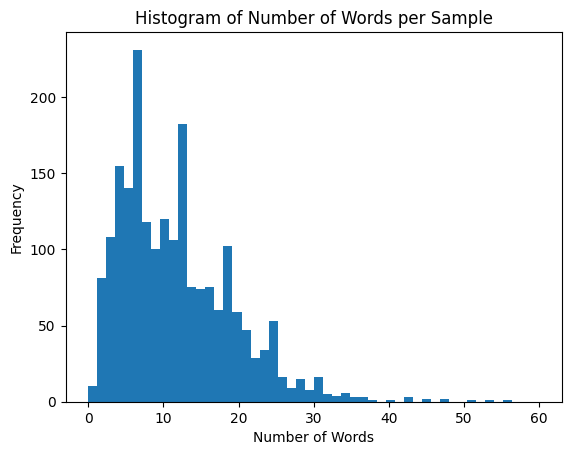

22/22 [==============================] - 0s 7ms/step - loss: 0.4098 - accuracy: 0.8195
Ratio of samples to mean words per sample:159.7248
Accuracy of the model used in (a):0.8341
Accuracy of the model used in (b):0.8195


In [7]:
import matplotlib.pyplot as plt

# 計算每個樣本的詞數
word_counts = [len(sentence.split()) for sentence in sentences_train]

# 繪製直方圖
plt.hist(word_counts, bins=50, range=(0, 60))
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words per Sample')
plt.show()

# 計算比率
num_samples = len(sentences_train)
mean_words_per_sample = sum(word_counts) / num_samples
ratio = num_samples / mean_words_per_sample

# 載入模型的權重
model_a.load_weights("binary_2gram.keras")
model_b.load_weights("sequence_model.keras")

# 比較準確性
accuracy_bag_of_bigrams = model_a.evaluate(binary_2gram_val_ds)[1]  # 計算(a)中詞袋模型的準確性
accuracy_sequence_model = model_b.evaluate(val_ds)[1]  # 計算(b)中序列模型的準確性

# 輸出結果
print("Ratio of samples to mean words per sample:{:.4f}".format(ratio))
print("Accuracy of the model used in (a):{:.4f}".format(accuracy_bag_of_bigrams))
print("Accuracy of the model used in (b):{:.4f}".format(accuracy_sequence_model))

> Ans: 計算得到的比率為 159.7248，該比率小於1,500。根據經驗法則，當比率小於1,500時，bag-of-bigrams model應表現較好。進一步比較(a)中bag-of-bigrams model的準確性為0.8341和(b)中sequence model的準確性為0.8195。根據結果，我們可以看出bag-of-bigrams model稍微優於sequence model，與經驗法則相符。

#### (d) GPT is a powerful pretrained foundation model that can generate text. (10%)

1. Firstly, try to load the model and tokenizer with checkpoint [`gpt2-xl`](https://huggingface.co/gpt2-xl) from the hugging face. You can load the model using `TFAutoModelForCausalLM` (or `AutoModelForCausalLM`) and `AutoTokenizer`.

2. Secondly, design a prompt and use the `generate()` method to generate 200 tokens that represent a positive review (For instance, you can feed the text "The movie is great" to the model and let it generate 200 tokens). 

3. Finally, feed the review to the best model you found in (a) and (b). Does the model predict the review as positive? 

Hint: You can try to tune the `do_sample`, `top_k`, `num_beams` or  `temperature` in the `generate()` function so that the generated text is more convincing. Again, refer to our lab for a brief introduction.

In [8]:
import tensorflow as tf
from transformers import TFAutoModelForCausalLM, AutoTokenizer
from tensorflow.keras import layers
# 載入模型和tokenizer
model_gpt2 = TFAutoModelForCausalLM.from_pretrained("gpt2-xl")
tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2-xl")

# 設計prompt
prompt = "The cat is adorable"

# 生成文本
input_ids = tokenizer_gpt2.encode(prompt, return_tensors="tf")
output = model_gpt2.generate(input_ids, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2, do_sample=True, top_k=50, temperature=0.5)

# 解碼生成的文本
generated_text = tokenizer_gpt2.decode(output[0], skip_special_tokens=True)

# 載入模型的權重
model_a = tf.keras.models.load_model("binary_2gram.keras")
model_b = tf.keras.models.load_model("sequence_model.keras")

# 將生成的文本轉換為 tf.RaggedTensor
generated_text_ragged = tf.ragged.constant([generated_text])

# 將生成的文本進行向量化
vectorization = tf.keras.layers.TextVectorization(max_tokens=10000)
vectorization.adapt(generated_text_ragged)

# 使用最佳模型預測向量化的文本
vectorized_text = vectorization(generated_text_ragged)
vectorized_text_padded = tf.keras.preprocessing.sequence.pad_sequences(vectorized_text, padding="post", maxlen=10000)
prediction_a = model_a.predict(vectorized_text_padded)[0]
prediction_b = model_b.predict(vectorized_text_padded)[0]

# 判斷預測結果是否為正面評論
is_positive_a = prediction_a > 0.5
is_positive_b = prediction_b > 0.5

# 輸出結果
print("Generated Text:")
print(generated_text)
print("Model (a) Prediction: Positive" if is_positive_a else "Model (a) Prediction: Negative")
print("Model (b) Prediction: Positive" if is_positive_b else "Model (b) Prediction: Negative")



All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-xl.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1/1 [==============================] - 2s 2s/step
Generated Text:
The cat is adorable, and I'm sure that the cat will be a great addition to the family.

We are not sure if the dog will like the new cat, but he seems to be quite fond of him. The dog is usually quite a bit more aggressive than the cats, so it's not likely that he will hate the little guy.
Model (a) Prediction: Positive
Model (b) Prediction: Positive


> Ans: 我使用的提示詞是"The cat is adorable"，(a)bag-of-bigrams model和(b)sequence model的預測都是Positive，與事實符合，生成文字為
"The cat is adorable, and I'm sure that the cat will be a great addition to the family.", "We are not sure if the dog will like the new cat, but he seems to be quite fond of him. The dog is usually quite a bit more aggressive than the cats, so it's not likely that he will hate the little guy."